In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import json
from tqdm import tqdm

In [4]:
dataset_folder = "Original"
meshblock_filename = "meshblock.shp"
dataset_name = "NSW_Election_2019"
data_id = "INDEX"
fold = "Bennelong"
meshblocks_id = "INDEX"
#meshblocks_id = "code_muni"
methods = ["Optimistic",  "RegGBSCV_R_Kappa_0.0", "TraditionalSCV"]

In [5]:

data_path = f"/home/tpinho/IJGIS/Datasets/{dataset_name}/{dataset_folder}/data.csv"
fold_path = f"/home/tpinho/IJGIS/Datasets/{dataset_name}/{dataset_folder}/folds/"
meshblock_path = f"/home/tpinho/IJGIS/Datasets/{dataset_name}/{dataset_folder}/meshblocks/{meshblock_filename}"
output_path = f"/home/tpinho/IJGIS/Datasets/{dataset_name}/{dataset_folder}"
methods_path = [os.path.join(fold_path,m) for m in methods]
methods_path

['/home/tpinho/IJGIS/Datasets/NSW_Election_2019/Original/folds/Optimistic',
 '/home/tpinho/IJGIS/Datasets/NSW_Election_2019/Original/folds/RegGBSCV_R_Kappa_0.0',
 '/home/tpinho/IJGIS/Datasets/NSW_Election_2019/Original/folds/TraditionalSCV']

In [6]:
def map_color(row):
    if row['Type'] == 'discarded':
        return '#AFABAB'
    elif row['Type'] == 'test':
        return '#9FC5E8'
    elif row['Type'] == 'removing_buffer':
        return '#EA9999'
    elif row['Type'] == 'train':
        return '#B6D7A8'
    elif row["Type"] == "missing":
        return "#ffffffff"
    else:
        return '#ffffffff'

map_color_dict = {
    
    "Train": "#05c793ff", 
    "Removing Buffer": "#ef436bff",
    "Test": "#003f5cff",
    
    

}

map_types = {
    "train": "1_Train",
    "removing_buffer": "2_Removing Buffer",
    "test": "3_Test"
    
}

map_approaches = {
    "Optimistic": "Optimistic",
    "RegGBSCV_R_Kappa_3.0": "RegGBSCV",
    "RegGBSCV_R_Kappa_0.0": "RegGBSCV",
    "TraditionalSCV": "Conservative",
    "RBuffer": "RBuffer"
}

      INDEX   INDEX_FOLD     TARGET                     geometry
0       874  Eden-Monaro  22.222222  POINT (147.69700 -35.92570)
1       875  Eden-Monaro  35.483871  POINT (148.12969 -36.21770)
2       896  Eden-Monaro  33.333333  POINT (147.86200 -35.67050)
3       909  Eden-Monaro  15.384615  POINT (148.05800 -35.96480)
4       911  Eden-Monaro  50.701590  POINT (148.01700 -35.78470)
...     ...          ...        ...                          ...
2757   2707    Shortland  48.986486  POINT (151.49444 -33.23835)
2758    985       Farrer  21.032746  POINT (142.16425 -34.18612)
2759    954       Farrer  22.124711  POINT (144.74829 -36.12787)
2760   2514     Richmond  85.714286  POINT (153.53975 -28.16860)
2761    867  Eden-Monaro  64.285714  POINT (149.12990 -35.27093)

[2762 rows x 4 columns]


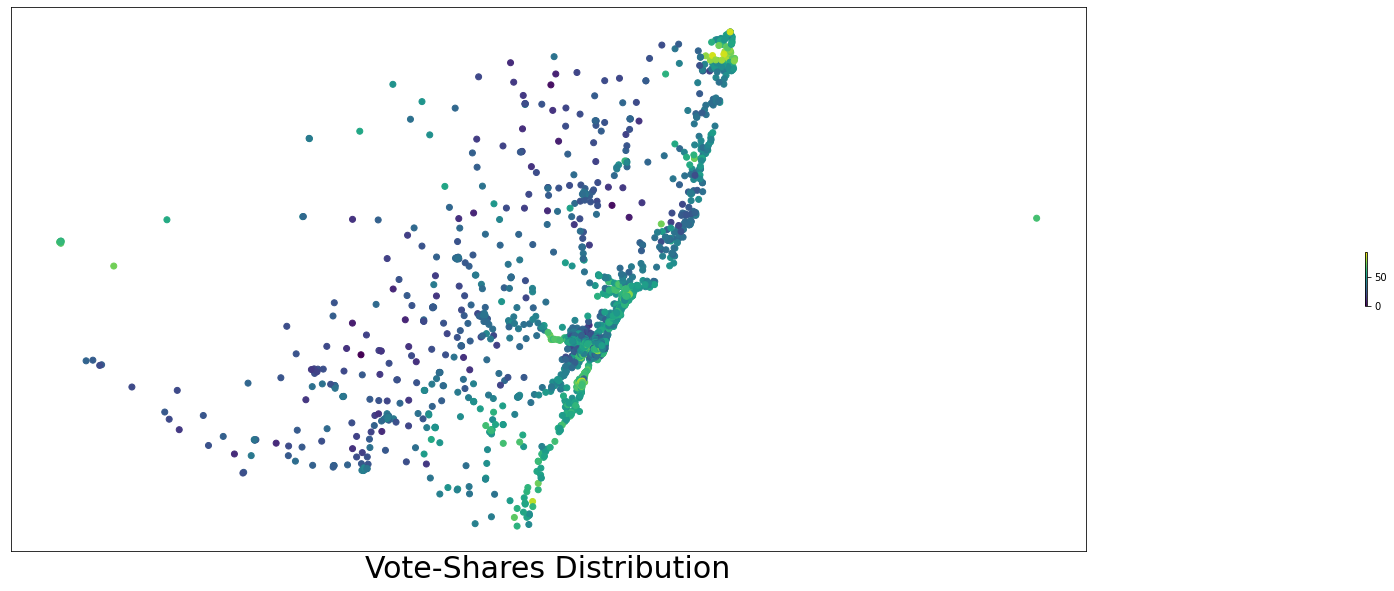

In [7]:
fig, ax = plt.subplots( 1, 1, figsize=(100,10))
meshblocks = gpd.read_file(meshblock_path)
print(meshblocks)
try:
    meshblocks.set_index(meshblocks_id, inplace=True)
except KeyError:
    pass

meshblocks.plot(column='TARGET', legend=True, ax=ax,legend_kwds={
        "shrink":.1})

ax.set_xticks([])
ax.set_yticks([]) 
ax.set_xlabel("Vote-Shares Distribution", fontsize = 30)
i=1

100%|██████████| 3/3 [00:28<00:00,  9.39s/it]


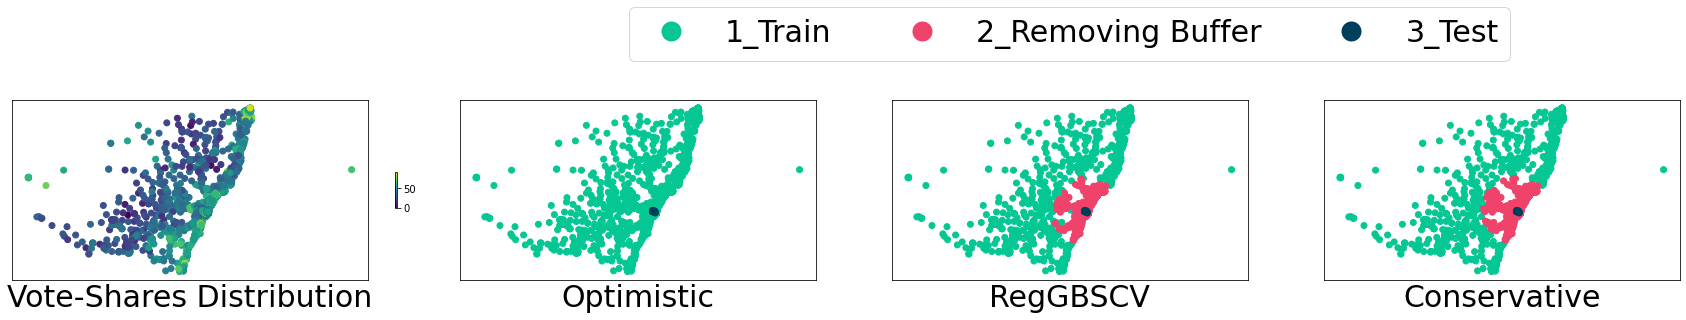

In [8]:


#fig, ax = plt.subplots( 1, 4, figsize=(30,10), gridspec_kw={'width_ratios': [1.26, 1, 1, 1]})
fig = plt.figure(figsize=(30,10))
ax = {
    0: fig.add_axes([0.0, 0.7, 0.25, 0.25], xticklabels=[]),
    1: fig.add_axes([0.2, 0.7, 0.25, 0.25], xticklabels=[]),
    2: fig.add_axes([0.4, 0.7, 0.25, 0.25]),
    3: fig.add_axes([0.6, 0.7, 0.25, 0.25]),
}
meshblocks = gpd.read_file(meshblock_path)
try:
    meshblocks.set_index(meshblocks_id, inplace=True)
except KeyError:
    pass

meshblocks.plot(column='TARGET', legend=True, ax=ax[0],legend_kwds={
        "shrink":.2})
ax[0].set_xticks([])
ax[0].set_yticks([]) 
ax[0].set_xlabel("Vote-Shares Distribution", fontsize = 30)
i=1
for method in tqdm(methods_path):
    fold_path = os.path.join(method,fold)
    meshblocks = gpd.read_file(meshblock_path)
    try:
        meshblocks.set_index(meshblocks_id, inplace=True)
    except KeyError:
        pass
    data = pd.read_csv(data_path, index_col=data_id)
    meshblocks.index = meshblocks.index.astype("int64")

    
    
    missing = [idx for idx in meshblocks.index if idx not in data.index]
   
    meshblocks["Type"] = [0] * len(meshblocks)
    with open(os.path.join(fold_path, "split_data.json"), 'r') as fp:
        split_data = json.load(fp)
    split_data["missing"] = missing
    
    for key in split_data.keys():
        joiner_index = [idx for idx in split_data[key] if idx in meshblocks.index]
        meshblocks.loc[joiner_index, "Type"] = key
    
       
    meshblocks = meshblocks[meshblocks["Type"]!="missing"]
    meshblocks["Type"] = [map_types[k] for k in meshblocks["Type"]]

    #meshblocks["Type"].replace(0, "train", inplace=True)
    meshblocks.sort_values(by="Type", inplace=True)
    color_list = meshblocks.apply(lambda row: map_color(row), axis=1)
    legend = False
    if i == 2:
        legend = True
    
    if i == 1:
       palette = colors.ListedColormap([list(map_color_dict.values())[0], list(map_color_dict.values())[2]])
    else:
        palette = colors.ListedColormap(list(map_color_dict.values()))
    meshblocks.plot(categorical=True, 
                #color=color_list,
                cmap=palette,
                #linewidth=.05, 
                #edgecolor='white',
                legend=legend,
                #markersize=100,
                column="Type",
                legend_kwds={"loc":'upper center', 
                             "bbox_to_anchor":(0.5, 1.6),
                             "fancybox":True,
                             "shadow":False,
                             "ncol":3,
                             "fontsize":30,
                             "markerscale":2}, 
                ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    ax[i].set_xlabel(map_approaches[methods[i-1]], fontsize = 30)
    plt.axis('on')
    i+=1
    #plt.savefig(os.path.join(fold_path, 'new_train_test_split.png'), dpi=1000)
    #plt.close()

IndexError: list index out of range

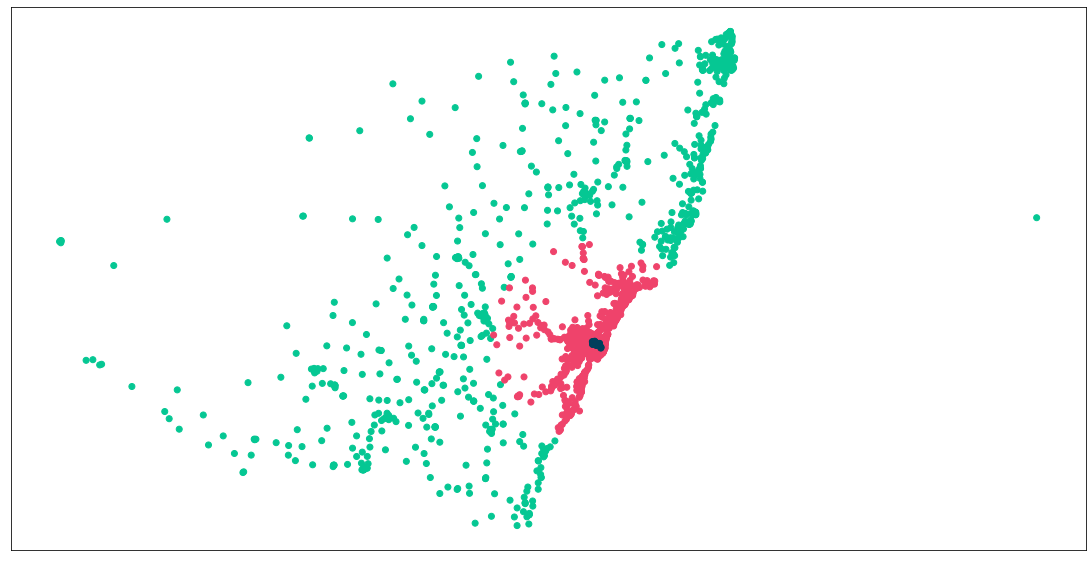

In [15]:
fig, ax = plt.subplots( 1, 1, figsize=(100,10))

meshblocks = gpd.read_file(meshblock_path)
try:
    meshblocks.set_index(meshblocks_id, inplace=True)
except KeyError:
    pass


method = "/home/tpinho/IJGIS/Datasets/NSW_Election_2019/Original/folds/TraditionalSCV"


fold_path = os.path.join(method,fold)
meshblocks = gpd.read_file(meshblock_path)
try:
    meshblocks.set_index(meshblocks_id, inplace=True)
except KeyError:
    pass
data = pd.read_csv(data_path, index_col=data_id)
meshblocks.index = meshblocks.index.astype("int64")



missing = [idx for idx in meshblocks.index if idx not in data.index]

meshblocks["Type"] = [0] * len(meshblocks)
with open(os.path.join(fold_path, "split_data.json"), 'r') as fp:
    split_data = json.load(fp)
split_data["missing"] = missing

for key in split_data.keys():
    joiner_index = [idx for idx in split_data[key] if idx in meshblocks.index]
    meshblocks.loc[joiner_index, "Type"] = key


meshblocks = meshblocks[meshblocks["Type"]!="missing"]
meshblocks["Type"] = [map_types[k] for k in meshblocks["Type"]]

#meshblocks["Type"].replace(0, "train", inplace=True)
meshblocks.sort_values(by="Type", inplace=True)
color_list = meshblocks.apply(lambda row: map_color(row), axis=1)
legend = False
if i == 2:
    legend = True

if i == 1:
    palette = colors.ListedColormap([list(map_color_dict.values())[0], list(map_color_dict.values())[2]])
else:
    palette = colors.ListedColormap(list(map_color_dict.values()))
meshblocks.plot(categorical=True, 
            #color=color_list,
            cmap=palette,
            #linewidth=.05, 
            #edgecolor='white',
            legend=legend,
            #markersize=100,
            column="Type",
            legend_kwds={"loc":'upper center', 
                        "bbox_to_anchor":(0.5, 1.6),
                        "fancybox":True,
                        "shadow":False,
                        "ncol":3,
                        "fontsize":30,
                        "markerscale":2}, 
            ax=ax)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel(map_approaches[methods[i-1]], fontsize = 30)
plt.axis('on')
i+=1
#plt.savefig(os.path.join(fold_path, 'new_train_test_split.png'), dpi=1000)
#plt.close()